In [45]:
# Clustering / Unsupervised Learning

In [46]:
import pandas as pd

from scipy.cluster.vq import kmeans,vq
from math import sqrt
from sklearn.cluster import KMeans

In [47]:
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

data_table = pd.read_html(sp500_url)
tickers = data_table[0]['Symbol'].values.tolist()
tickers = [s.replace('\n', '') for s in tickers]
tickers = [s.replace('.', '-') for s in tickers]
tickers = [s.replace(' ', '') for s in tickers]

In [48]:
def load_data(end_date):
    from datetime import timedelta
    prices_list = []

    start_date = end_date - timedelta(days=365)
    for ticker in tickers:
        prices = yf.download(ticker, start=start_date, end=end_date, interval="1d")['Close']
        prices = pd.DataFrame(prices)
        prices.columns = [ticker]
        prices_list.append(prices)

    prices_df = pd.concat(prices_list,axis=1)
    prices_df.sort_index(inplace=True)

    returns = pd.DataFrame()
    returns['Returns'] = prices_df.pct_change().mean() * 252
    returns['Volatility'] = prices_df.pct_change().std() * sqrt(252)
    returns = returns.dropna()
    return returns

In [49]:
def draw_elbow(returns):
    ### Elbow Curve
    data = np.asarray([np.asarray(returns['Returns']), np.asarray(returns['Volatility'])]).T
    distortions = []
    for k in range(2, 20):
        k_means = KMeans(n_clusters=k)
        k_means.fit(data)
        distortions.append(k_means.inertia_)

    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(2, 20), distortions)
    plt.grid(True)
    plt.xlabel("Number of clusters")
    plt.ylabel("Percent of Variance explained")
    plt.title('Elbow curve')
    # fig.savefig("elbow_curve.png")
    return data

In [50]:
def plot(data, returns, clusters):
    centroids,_ = kmeans(data, clusters)

    idx,_ = vq(data,centroids)
    details = [(name,cluster) for name, cluster in zip(returns.index,idx)]
    details_df = pd.DataFrame(details)
    details_df.columns = ['Ticker','Cluster']

    clusters_df = returns.reset_index()
    clusters_df['Cluster'] = details_df['Cluster']
    clusters_df.columns = ['Ticker', 'Returns', 'Volatility', 'Cluster']

    fig = px.scatter(clusters_df, x="Returns", y="Volatility", color="Cluster", hover_data=["Ticker"])
    fig.update(layout_coloraxis_showscale=False)
    fig.update_traces(
        marker=dict(size=8, symbol="diamond", line=dict(width=2, color="DarkSlateGrey"))
    )
    fig.show()
    # fig.write_image("plot.png")

In [51]:
import plotly.express as px

In [52]:
import datetime
until_eo24 = datetime.date(2025, 1, 1)
returns_eo24 = load_data(until_eo24)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

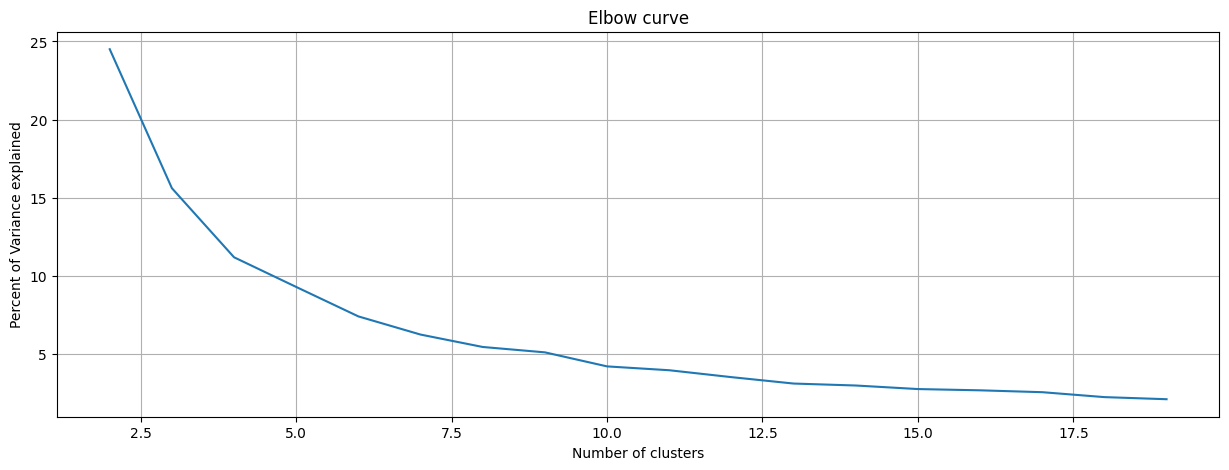

In [53]:
data_eo24 = draw_elbow(returns_eo24)

In [54]:
# plot 2025-01-01
plot(data_eo24, returns_eo24, 3)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

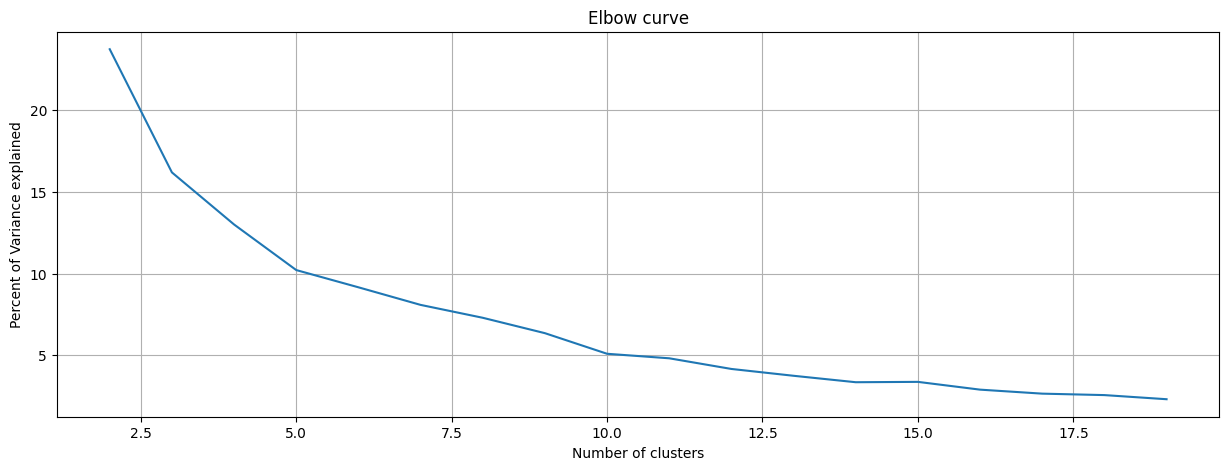

In [55]:
# elbow 2025-01-13
import datetime
until_may = datetime.date(2025, 5, 13)
returns_may = load_data(until_may)
data_may = draw_elbow(returns_may)

In [56]:
plot(data_may, returns_may, 5)

In [58]:
plot(data_may, returns_may, 3)

In [ ]:
# Supervised

In [59]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

start_date = "2018-01-01"
end_date = "2023-01-01"

ticker ="AAPL"
df = yf.Ticker(ticker).history(start=start_date, end=end_date)
df = df[["Open", "High", "Low", "Close", "Volume"]]

df["Target"] = df["Close"].shift(-1)
df.dropna(inplace=True)


In [60]:
X = df.drop(columns=["Target"])
y = df["Target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
results = pd.DataFrame({
    "Date": df.index[-len(y_test):],
    "Actual": y_test.values,
    "RandomForest": rf_preds,
}).set_index("Date")

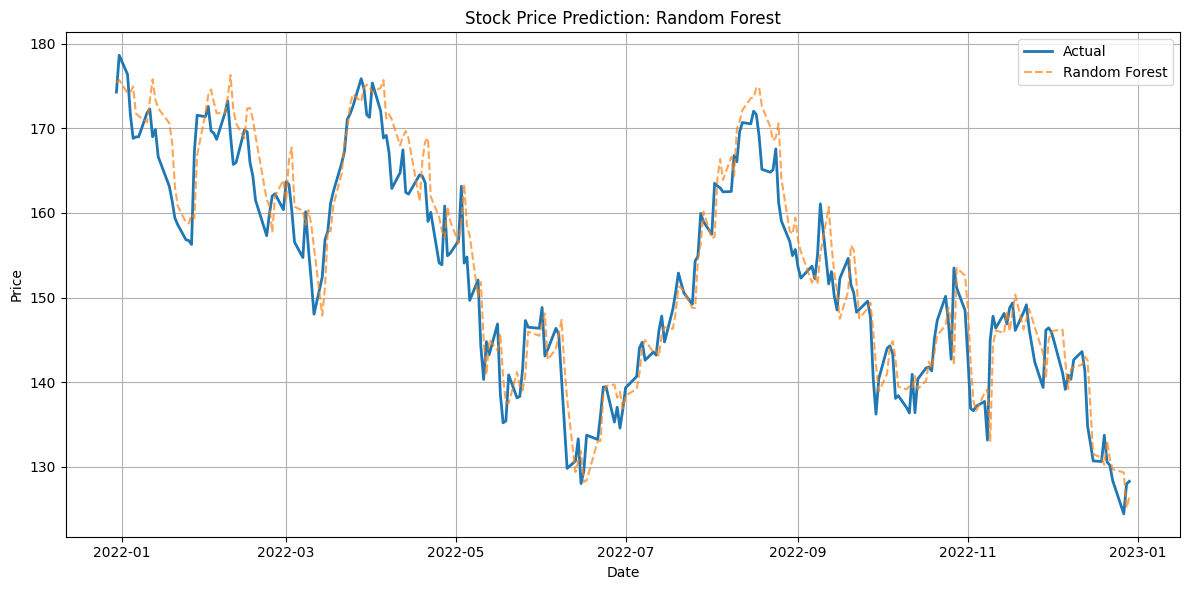

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(results.index, results["Actual"], label="Actual", linewidth=2)
plt.plot(results.index, results["RandomForest"], label="Random Forest", alpha=0.7, linestyle='dashed')
plt.title("Stock Price Prediction: Random Forest")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [62]:
print(f"Random Forest RMSE: {rf_rmse:.2f}")

Random Forest RMSE: 3.99


In [63]:
import os
from dotenv import load_dotenv
load_dotenv()
OPENAI_KEY = os.getenv("ai.openai.pwd")

In [64]:
system_content = """“I have a computer science background. I have been working for many different companies on digital transformation projects. I understand well how AI can change companies' businesses. I am looking for stocks of companies that might get transformed through AI but have not yet been overrun by investors.

I want to be financially independent in five years. I have approximately 500,000 USD available for investment. I want to be able to calculate the money I make passively with an average yield of assets (interests, staking rewards, dividends).

I mainly hold stocks and ETFs. I also hold bonds and crypto. I want to keep some amount in index funds.

I am interested in the future of autonomous driving and the monetization of climate change mitigation. I also believe in the increase in demand of reliable, non-volatile energy sources, such as nuclear energy due to the increasing demand of nuclear energy. I am also open to alternatives to nuclear energy.

I use Interactive Broker and Alpaca as brokers. I use cold wallets to store cryptocurrency.

I can take risks if decisions have been thoroughly researched. If the valuation of the asset is temporarily lower, I do not have a problem as long as I see a long-term potential. I am okay with shorting some positions but I prefer long-term quality investing. I do not do day trading.

I want to diversify. Diversification also includes assets worldwide, as I see political risks in the US. Otherwise, I am fine with holding most assets in the US market.

I am a US-American citizen. My tax residency is in the UK. I want to minimize the taxes we have to pay.

I do not like to invest in the tobacco industry and companies that ignore animal rights.
"""
question = """I want to find companies with a similar outlook to Netflix's in the early years. I want to buy low and sell at a high price in some years high. These companies shall be able to scale worldwide, have a B2C subscription model, and have a strong economic moat. These companies shall have a room to grow and already be listed on the stock exchange. Please give me three examples and the reasons why you chose them."""

In [ ]:
# Open AI
from openai import OpenAI

client = OpenAI(
  api_key=OPENAI_KEY
)

completion = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {"role": "system", "content": system_content},
    {"role": "user", "content": question}
  ]
)


In [24]:
answer = completion.choices[0].message.content
print(answer)

Finding companies that resemble Netflix in its early years involves identifying those with a scalable business model, a strong economic moat, a B2C subscription approach, and significant room for growth. Here are three companies that might fit this profile:

1. **Spotify Technology S.A. (SPOT):**
   - **Scalability:** As a leading music streaming service, Spotify has a global presence with a scalable platform that can expand its user base without proportional increases in costs.
   - **B2C Subscription Model:** Spotify operates on a freemium model with a robust subscription base, providing predictable revenue streams.
   - **Economic Moat:** Spotify's moat is built on its massive music library, strong brand recognition, and partnerships with various industry stakeholders. The network effects generated by its user base and playlist culture reinforce its position.
   - **Growth Potential:** With continued expansion into new markets and investments in exclusive content like podcasts, Spot

In [25]:
import os
from dotenv import load_dotenv

load_dotenv()
GEMINI_KEY = os.getenv("ai.gemini.key")
import google.generativeai as genai
genai.configure(api_key=GEMINI_KEY)

model = genai.GenerativeModel('gemini-1.5-pro-latest')
response = model.generate_content(question)
print(response.candidates[0].content.parts[0])


text: "It\'s important to remember that past performance is not indicative of future results, and investing in any stock carries inherent risk.  Finding the \"next Netflix\" is extremely difficult. However, here are three publicly traded companies with some similarities to Netflix\'s early model, focusing on scalable B2C subscriptions, potential moats, and room for growth.  These are just examples and require your own thorough research before making any investment decisions:\n\n1. **Spotify (SPOT):**\n\n    * **Similarities to Early Netflix:** Spotify is dominant in the music streaming space, much like Netflix was in DVD rentals and then early streaming.  They operate on a subscription model and benefit from network effects (more users attract more artists, which attracts more users).\n    * **Scalability:** Music is a global language. Spotify has significant room to grow internationally, particularly in emerging markets with increasing internet penetration.\n    * **Economic Moat:**  

In [26]:
temperature = 1
max_token = 1000
model = 'gemini-2.0-flash'
model_flash = genai.GenerativeModel(model)
response = model_flash.generate_content(question,
                                        generation_config = genai.GenerationConfig(
                                        max_output_tokens=max_token,
                                        temperature=temperature,
                                    ))
answer = response.candidates[0].content.parts[0].text
print(answer)


Okay, here are three publicly traded companies that share some similarities with early-stage Netflix and fit your criteria:

**Important Disclaimer:** *Investing in the stock market involves risk, and past performance is not indicative of future results. These suggestions are based on publicly available information and should not be considered financial advice. You should conduct thorough research and consult with a financial advisor before making any investment decisions.*

Here are the companies and the reasoning behind their inclusion:

**1. Spotify (SPOT)**

*   **Similarities to Early Netflix:**
    *   **Subscription-Based Model (B2C):**  Spotify has a freemium model, which it hopes the free version will convert to paid ones.
    *   **Scalable Worldwide:**  Spotify is present in numerous countries, and its digital distribution allows for easy expansion into new markets.  Music is a universal language, facilitating global adoption.
    *   **Strong Economic Moat (Potentially):** 

In [ ]:
import anthropic
import os
from dotenv import load_dotenv
load_dotenv()
CLAUDE_KEY = os.getenv("ai.claude.key")

client = anthropic.Anthropic(api_key=CLAUDE_KEY)

model = "claude-3-7-sonnet-20250219"
message = client.messages.create(
    model=model,
    max_tokens=1000,
    temperature=0,
    system=system_content,
    messages=[
        {"role": "user", "content": question}
    ]
)
print(message.content)

In [ ]:
import os
from mistralai import Mistral
load_dotenv()
MISTRAL_KEY = os.getenv("ai.mistral.key")
model = "mistral-large-latest"
client = Mistral(api_key=MISTRAL_KEY)
chat_response = client.chat.complete(
  model = model,
  messages = [
    {
      "role": "user",
      "content": question,
    },
  ]
)
print(chat_response.choices[0].message.content)


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

def ask_huggingface(model_name, query):
    model = AutoModelForCausalLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    prompt = f"<s>[INST] <<SYS>>{system_content}<</SYS>>\n\n{query} [/INST]"

    inputs = tokenizer(prompt, return_tensors="pt", add_special_tokens=False).input_ids.to(model.device)
    outputs = model.generate(input_ids=inputs, max_length=4096)[0]

    answer_start = int(inputs.shape[-1])
    pred = tokenizer.decode(outputs[answer_start:], skip_special_tokens=True)
    return pred

model = "AdaptLLM/finance-chat"
response = ask_huggingface(model,  question)


In [1]:
import pandas as pd
import yfinance as yf
ticker = "ATOM-USD"
data = yf.Ticker(ticker).history(start="2021-01-01", end="2023-01-01")
df = pd.DataFrame(data).dropna()

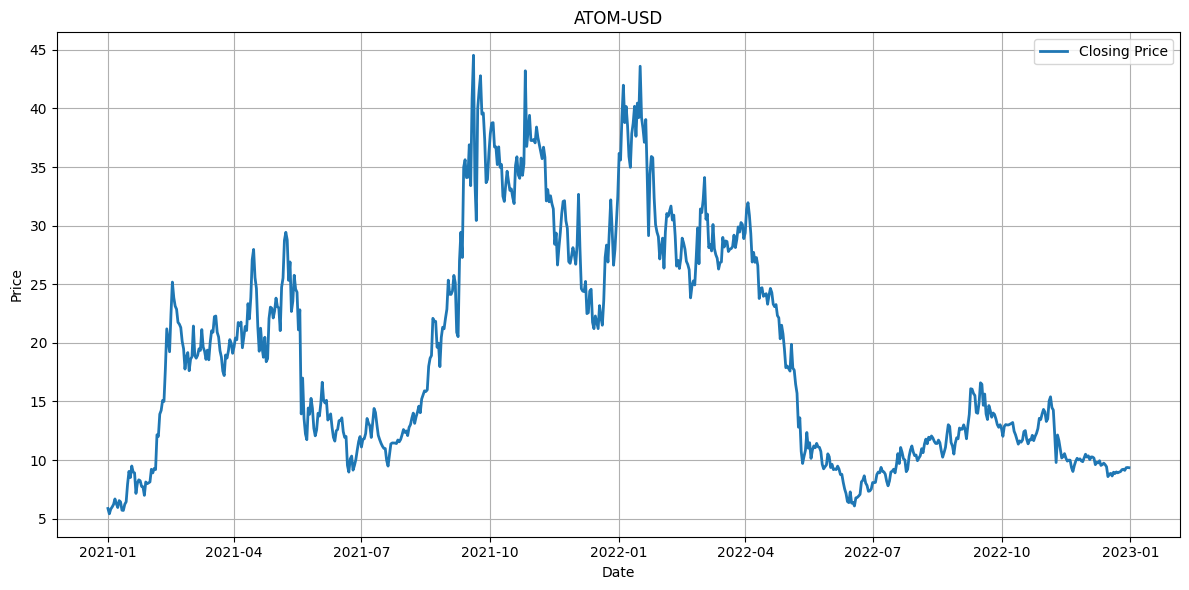

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], label="Closing Price", linewidth=2)
plt.title("ATOM-USD")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 1.3

In [1]:
import pandas as pd
import yfinance as yf
ticker = "NVDA"
data = yf.Ticker(ticker).history(start="2016-01-01", end="2025-01-01")
df = pd.DataFrame(data).dropna()

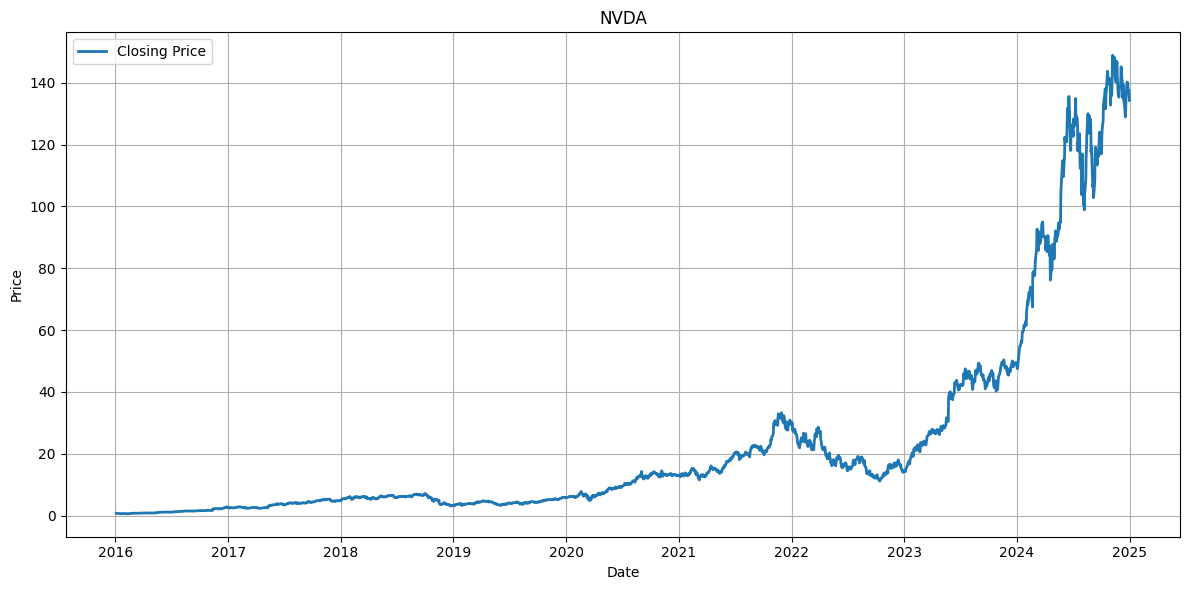

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], label="Closing Price", linewidth=2)
plt.title("NVDA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 8.1

In [6]:
import pandas as pd
import yfinance as yf
import datetime
ticker = "NVDA"
data = yf.Ticker(ticker).history(start="2025-01-01", end="2025-06-13")["Close"]
df = pd.DataFrame(data).dropna()
nvdia = yf.Ticker(ticker)
ad = nvdia.get_analyst_price_targets()

In [7]:
# for pretty print
mean = int(round(ad["mean"],0))
high = int(round(ad["high"],0))
low = int(round(ad["low"],0))

In [8]:
def calculate_diff(current, target):
    result = round((target - current) / current * 100, 2)
    prefix = "" if result < 0 else "+"
    return f"{prefix}{result}%"

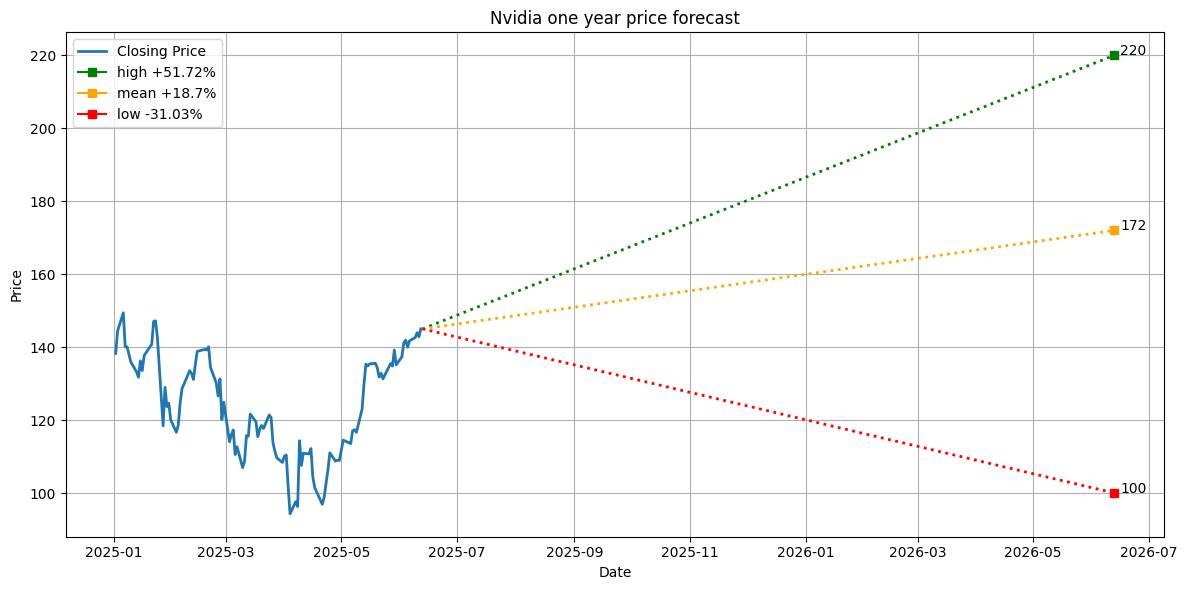

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], label="Closing Price", linewidth=2)
plt.title("Nvidia one year price forecast")
plt.xlabel("Date")
plt.ylabel("Price")

x = [datetime.datetime(2025, 6, 13), datetime.datetime(2026, 6, 13)]

plt.plot(x, [ad["current"], high], linestyle=':', linewidth=2, color="green")
plt.plot(x, [ad["current"], mean], linestyle=':', linewidth=2, color="orange")
plt.plot(x, [ad["current"], low], linestyle=':', linewidth=2, color="red")
plt.plot(datetime.datetime(2026, 6, 13), high, marker='s', linestyle='-', color='green', label="high " + calculate_diff(ad["current"], ad["high"]))
plt.plot(datetime.datetime(2026, 6, 13), mean, marker='s', linestyle='-', color='orange', label="mean " + calculate_diff(ad["current"], ad["mean"]))
plt.plot(datetime.datetime(2026, 6, 13), low, marker='s', linestyle='-', color='red', label="low " + calculate_diff(ad["current"], ad["low"]))
plt.annotate(high, [datetime.datetime(2026, 6, 16), high])
plt.annotate(mean, [datetime.datetime(2026, 6, 16), mean])
plt.annotate(low, [datetime.datetime(2026, 6, 16), low])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()